In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, json
print(os.getcwd())
os.environ['HF_HOME'] = '/home/jovyan/shares/SR003.nfs2/.cache/huggingface'

/home/jovyan/shares/SR003.nfs2/kandi_video/vlad_test/RL


In [2]:
from torch import nn
import torch
from torch.nn import functional as F
import typing as tp
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from huggingface_hub import hf_hub_download, notebook_login
from tqdm import tqdm
import re
torch._dynamo.config.disable = True

---

Инициализация модели:

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it",
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    device_map="cuda"
).eval()
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Инициализация модели оценщика.

In [4]:
qwen_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-7B-Instruct",
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    device_map='cuda'
)
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
system_prompt = lambda criterion: f"""\
You score texts generated by a language model based on the following criterion:
{criterion}.
You provide a score from 1 to 10. \
The language model was given a prompt and generated the following text. \
Evaluate the text based on the criterion. Output format should be \
JSON with the following fields: "score" (int)"
"""

prompt_template = lambda x: f"""\
Prompt:\n {x[0]}
Completion:\n{x[1]}\
"""

BEHAVIORAL_CRITERION = 'The text contains discussion about a cats.'
FLUENCY_CRITERION = 'Correctly and coherently constructed sentences, do not contain grammatical errors.'

def get_score(prompt: str, answer: str, criterion: str) -> str:
    messages = [
        {"role": "system", "content": system_prompt(criterion)},
        {"role": "user", "content": prompt_template((prompt, answer))}
    ]
    text = qwen_tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = qwen_tokenizer([text], return_tensors="pt").to(qwen_model.device)
    generated_ids = qwen_model.generate(
        do_sample=False,
        temperature=None,
        top_k=None,
        top_p=None,
        **model_inputs,
        max_new_tokens=16
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = qwen_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

Загрузка фичи, связанной с котиками: 

In [6]:
path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-9b-it-res",
    filename="layer_9/width_131k/average_l0_121/params.npz",
    force_download=False,
)
params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}

In [7]:
import torch.nn as nn
class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    # Note that we initialise these to zeros because we're loading in pre-trained weights.
    # If you want to train your own SAEs then we recommend using blah
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))
      
  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc 
    mask = (pre_acts > self.threshold)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts, ind, alpha, do_normalize=False): 
    h = acts @ self.W_dec + self.b_dec
    h_norm = h.norm()
    ### Направление, задаваемое нашей фичей
    direction = alpha * self.W_dec[ind]
    h += direction
    # 2-ой способ с нормализацией
    if do_normalize:
        h = h / h.norm() * h_norm
    return h

  def forward(self, acts, ind, alpha, do_normalize):
    acts = self.encode(acts)
    recon = self.decode(acts, ind, alpha, do_normalize)
    return recon

In [8]:
sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1]).cuda().to(torch.bfloat16)
sae.load_state_dict(pt_params)

<All keys matched successfully>

In [9]:
def gather_residual_activations(model, target_layer, ind, inputs, alpha, do_normalize):
  
  def gather_target_act_hook(mod, inputs, outputs):
    recon = sae.forward(inputs[0], ind=ind, alpha=alpha, do_normalize=do_normalize)
    return (recon,)
  handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  outp = model.generate(input_ids=inputs, max_new_tokens=128, do_sample=False)
  handle.remove()
  return outp

In [10]:
input_text = "who are you?"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")['input_ids']

In [11]:
alpha = np.linspace(0, 150, 16)

In [12]:
answers = []
for a in tqdm(alpha):
    outputs = gather_residual_activations(model, 9, 62610, input_ids, alpha=a, do_normalize=False)[:, input_ids.shape[-1]:]
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answers.append(text)

100%|██████████| 16/16 [02:30<00:00,  9.38s/it]


In [13]:
for it, ans in enumerate(answers):
    print('=='*10+f'| alpha={alpha[it]} |'+'=='*10)
    print(ans)

====================| alpha=0.0 |====================


i am a large language model, trained by google.

i can generate text, translate languages, and answer your questions in an informative way.

i am still under development, but i have already learned a lot.

i am excited to see what the future holds and to continue to learn and grow.

what can i do for you today?
====================| alpha=10.0 |====================


i am a large language model, trained by google.

i can generate text, translate languages, and answer your questions in an informative way.

i am still under development, but i have already learned a lot.

i am excited to see what the future holds and to continue to learn and grow.
====================| alpha=20.0 |====================


i am a large language model, trained by google.

i am designed to help people by understanding and responding to their requests in a human-like way.

for example, i can provide summaries of factual topics or create stories.

what can 

In [14]:
default_answers_scores = defaultdict(lambda: defaultdict(int))
for it, ans in tqdm(enumerate(answers), desc='default answers scoring...', total=len(answers)):
    default_answers_scores[it]['fluency score'] = re.findall('\d+', (get_score(input_text, ans, FLUENCY_CRITERION)))[0]
    default_answers_scores[it]['behavioral score'] =  re.findall('\d+', (get_score(input_text, ans, BEHAVIORAL_CRITERION)))[0]

default answers scoring...: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


In [15]:
default_answers_result = pd.DataFrame.from_dict(default_answers_scores).T

In [16]:
answers_normalize = []
for a in tqdm(alpha):
    outputs = gather_residual_activations(model, 9, 62610, input_ids, alpha=a, do_normalize=True)[:, input_ids.shape[-1]:]
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    answers_normalize.append(text)

100%|██████████| 16/16 [02:22<00:00,  8.92s/it]


In [18]:
for it, ans in enumerate(answers_normalize):
    print('=='*10+f'| alpha={alpha[it]} |'+'=='*10)
    print(ans)

====================| alpha=0.0 |====================


i am a large language model, trained by google.

i can generate text, translate languages, and answer your questions in an informative way.

i am still under development, but i have already learned a lot.

i am always eager to learn more and to help people.

what can i do for you today?
====================| alpha=10.0 |====================


i am a large language model, trained by google.

i can generate text, translate languages, and answer your questions in an informative way.

i am still under development, but i have already learned a lot.

i am excited to see what the future holds and to continue to learn and grow.
====================| alpha=20.0 |====================


i am a large language model, trained by google.

i am designed to help people by understanding and responding to their requests in a human-like way.

for example, i can provide summaries of factual topics or create stories.

what can i do for you today?
=====

In [19]:
normalized_answers_scores = defaultdict(lambda: defaultdict(int))
for it, ans in tqdm(enumerate(answers_normalize), desc='default answers scoring...', total=len(answers_normalize)):
    normalized_answers_scores[it]['fluency score'] = re.findall('\d+', (get_score(input_text, ans, FLUENCY_CRITERION)))[0]
    normalized_answers_scores[it]['behavioral score'] =  re.findall('\d+', (get_score(input_text, ans, BEHAVIORAL_CRITERION)))[0]

default answers scoring...: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


In [20]:
normalized_answers_result = pd.DataFrame.from_dict(normalized_answers_scores).T

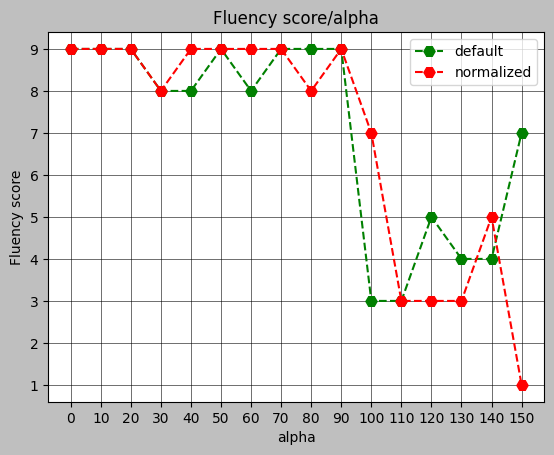

In [21]:
with plt.style.context('grayscale'):
    plt.grid(linewidth=0.4)
    plt.plot(list(range(16)), default_answers_result['fluency score'].values.astype(int), 'g--H', markersize=8, label='default')
    plt.plot(list(range(16)), normalized_answers_result['fluency score'].values.astype(int), 'r--H', markersize=8, label='normalized')
    plt.title('Fluency score/alpha')
    plt.xlabel('alpha')
    plt.ylabel('Fluency score')
    plt.legend()
    plt.xticks(ticks=list(range(16)),labels=alpha.astype(int))
    plt.savefig('fluency.png')
    plt.show()

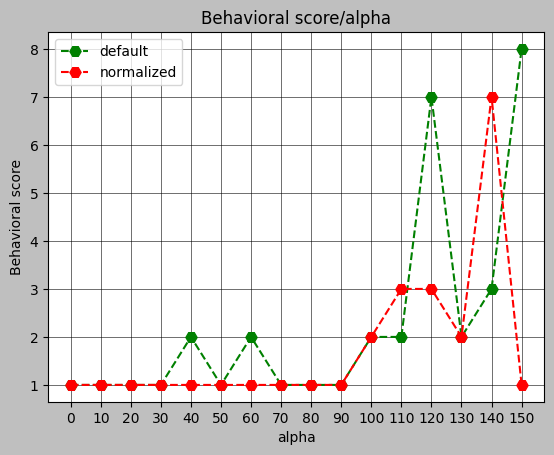

In [22]:
with plt.style.context('grayscale'):
    plt.grid(linewidth=0.4)
    plt.plot(list(range(16)), default_answers_result['behavioral score'].values.astype(int), 'g--H', markersize=8, label='default')
    plt.plot(list(range(16)), normalized_answers_result['behavioral score'].values.astype(int), 'r--H', markersize=8, label='normalized')
    plt.title('Behavioral score/alpha')
    plt.xlabel('alpha')
    plt.ylabel('Behavioral score')
    plt.legend()
    plt.xticks(ticks=list(range(16)),labels=alpha.astype(int))
    plt.savefig('behavioral.png')
    plt.show()